In [1]:
import numpy as np
import scipy.stats as sps
from glob import glob
import pickle, yaml
import time
from array import array
import pandas as pd
import matplotlib.pyplot as plt
import uproot as ur
import ROOT as rt
import root_numpy as rtnp
import ROOT.RooFit as rf
from scipy.special import erf
import sys, os
sys.path.append('../lib')
if os.environ['CMSSW_VERSION'] != 'CMSSW_10_2_3':
    raise
from histo_utilities import create_TH1D, create_TH2D, std_color_list, SetMaxToMaxHist, make_ratio_plot
from cebefo_style import Set_2D_colz_graphics
from progressBar import ProgressBar

from analysis_utilities import drawOnCMSCanvas, DSetLoader

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Simulation Internal"

donotdelete = []

Welcome to JupyROOT 6.12/07


In [11]:
catText = rt.TLatex()
catText.SetTextAlign(31)
catText.SetTextSize(0.06)
catText.SetTextFont(42)
catText.SetTextSize(0.05)

In [7]:
catName = 'High'
expectedLumi = {'Low':6.4, 'Mid':20., 'High':26.} #fb^-1
lumi_tot = expectedLumi[catName]
CMS_lumi.integrated_lumi = lumi_tot

In [2]:
ds_pm = DSetLoader('B0_MuNuDstst_PipPim_PUc0')

In [3]:
dTkSide_pm = rtnp.root2array(ds_pm.skimmed_dir + '/{}_trkCtrl_{}.root'.format(catName, 'bare'))

In [69]:
def computeWidthVarWeights(ds, selItems=[], newGamma=None, relScale=0.1, keepNorm=False): #Gamma modification factor
    # selItems=[ [pdgId, mass, Gamma] ]
    w = np.ones_like(ds['mu_pt'])
    up = np.ones_like(ds['mu_pt'])
    down = np.ones_like(ds['mu_pt'])
    for i, (pdgId, mass, gamma) in enumerate(selItems):
        # print pdgId, mass, gamma
        dx2 = np.clip(np.square(ds['MC_MassCharmedBDaughter'] - mass), 0, 9*(gamma**2))
        
        if not (newGamma is None) and not (newGamma[i] is None):
                gNew = newGamma[i]
                wCentral = ((dx2 + gamma**2)*gNew)/(gamma*(dx2 + gNew**2))
                gUp = gNew*(1+relScale)
                gDown = gNew*(1-relScale)
        else:
            wCentral = np.ones_like(dx2)
            gUp = gamma*(1+relScale)
            gDown = gamma*(1-relScale)

        wUp = ((dx2 + gamma**2)*gUp)/(gamma*(dx2 + gUp**2))
        wDown = ((dx2 + gamma**2)*gDown)/(gamma*(dx2 + gDown**2))

        sel = np.abs(ds['MC_DstMotherPdgId'].astype(np.int)) == np.abs(pdgId)
        w = np.where(sel, wCentral, w)
        up = np.where(sel, wUp, up)
        down = np.where(sel, wDown, down)

    if keepNorm:
        w = w * (w.shape[0]/np.sum(w))
        up = up * (w.shape[0]/np.sum(up))
        down = down * (w.shape[0]/np.sum(down))
    return w, up/w, down/w

In [73]:
widthMods = [[100413, 2.640, 0.200]]
wC, wVarUp, wVarDw = computeWidthVarWeights(dTkSide_pm, 
                                            selItems=widthMods, 
                                            newGamma=[0.35],
                                            relScale=0.2,
                                            keepNorm=True
                                           )

In [74]:
print '{:2.2e}'.format(np.sum(wC))
print '{:2.2e}'.format(np.sum(wC*wVarUp))
print '{:2.2e}'.format(np.sum(wC*wVarDw))

1.04e+05
1.04e+05
1.04e+05


Warning in <TROOT::Append>: Replacing existing TH1: hNom (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hCentral (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hUp (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hDw (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


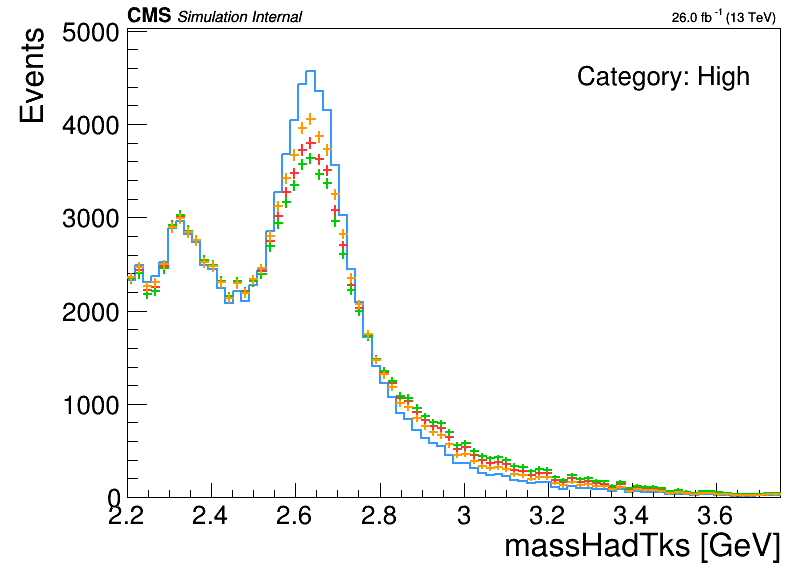

In [68]:
var = 'massHadTks'
# var = 'massVisTks'
# var = 'MC_MassCharmedBDaughter'
h = create_TH1D(dTkSide_pm[var], name='hNom',
                title='',
                axis_title=[var+' [GeV]', 'Events'],
                binning=[80, 2.2, 3.75],
#                 binning=[80, 2.8, 5.3],
                color=0
               )

hCt = create_TH1D(dTkSide_pm[var], name='hCentral',
                binning=h.binning,
                color=1,
                weights=wC
               )

hUp = create_TH1D(dTkSide_pm[var], name='hUp',
                binning=h.binning,
                color=2,
                weights=wC*wVarUp
               )

hDw = create_TH1D(dTkSide_pm[var], name='hDw',
                binning=h.binning,
                color=3,
                weights=wC*wVarDw
               )

h_list = [h, hCt, hUp, hDw]
m = SetMaxToMaxHist(h_list)

c = drawOnCMSCanvas(CMS_lumi, h_list, 'same')
# leg.Draw()
catText.DrawLatexNDC(0.95, 0.85, 'Category: {}'.format(catName));